#### Using Chain rule, we can calculate value of gradient easier. 



In [135]:
# implementation of Multiply Node.
# focus on forward, backward function.

import numpy as np 

class MulLayer:
    def __init__(self):
        self.x = None
        self.y = None
    
    def forward(self, x, y):
        self.x = x
        self.y = y
        out = x * y
        
        return out

    def backward(self, dout):
        dx = dout * self.y
        dy = dout * self.x

        # xy = z
        # dz / dx = y, dz / dy = x.

        return dx, dy

In [136]:
# Example - mullyaer

apple = 100
apple_num = 2
tax = 1.1

mul_apple_layer = MulLayer()
mul_tax_layer = MulLayer()

# forward
apple_price = mul_apple_layer.forward(apple, apple_num)
price = mul_tax_layer.forward(apple_price, tax)

print(price)

# backward
dprice = 1

dapple_price, dtax = mul_tax_layer.backward(dprice)
dapple, dapple_num = mul_apple_layer.backward(dapple_price)

print(dapple, dapple_num, dtax)

220.00000000000003
2.2 110.00000000000001 200


In [137]:
# implementation of Add Node.
class AddLayer:
    def __init__(self):
        pass

    def forward(self, x, y):
        out = x + y
        return out
    
    def backward(self, dout):
        dx = dout * 1
        dy = dout * 1
        return dx, dy 

## Some activation functions

### 1. ReLU

y = x if x>=0, 0 if x<0

so, dy/dx = 1 if x >= 0, 0 if x <0


In [ ]:
class ReLU:
    def __init__(self):
        self.mask = None

    def forward(self, x):
        self.mask = (x <= 0)
        out = x.copy()

        out[self.mask] = 0

        return out
    
    def backward(self, dout):
        dout[self.mask] = 0
        dx = dout

        return dx

### 2. Sigmoid.

y = 1 / 1 + exp(-x).

#### forward

x -> -x -> exp(-x) -> 1 + exp(-x) -> 1 / (1 + exp(-x))

#### backward

$\frac{\partial L}{\partial y}(y^2exp(-x))$ <- $\frac{\partial L}{\partial y}(-y^2exp(-x))$ <- $\frac{\partial L}{\partial y}(-y^2)$ <- $\frac{\partial L}{\partial y}(-y^2)$ <- $\frac{\partial L}{\partial y}$

and $\frac{\partial L}{\partial y}(y^2exp(-x))$ = $\frac{\partial L}{\partial y}(y(1-y))$

In [139]:
class Sigmoid:
    def __init__(self):
        self.out = None

    def forward(self, x):
        out = 1 / (1 + np.exp(-x))
        self.out = out

        return out
    
    def backward(self, dout):
        dx = dout * (1.0 - self.out) * self.out
        
        return dx

## Affine, Softmax Layer

In [ ]:
class Affine:
    def __init__(self, W, b):
        self.W = W
        self.b = b
        self.x = None
        self.dW = None
        self.db = None

    def forward(self, x):
        self.x = x
        out = np.dot(x, self.W) + self.b

        return out
    
    def backward(self, dout):
        dx = np.dot(dout, self.W.T) # δL/δx = δL/δy * δy/δx = dout * self.W.T

        self.dW = np.dot(self.x.T, dout)

        self.db = np.sum(dout, axis = 0)

        return dx

In [141]:
def softmax(x):
    if x.ndim == 2:
        c = np.max(x, axis=1, keepdims=True)
        exp_x = np.exp(x - c)
        sum_exp_x = np.sum(exp_x, axis=1, keepdims=True)
        return exp_x / sum_exp_x
    
    else:
        c = np.max(x)
        exp_x = np.exp(x - c)
        sum_exp_x = np.sum(exp_x)
        return exp_x / sum_exp_x

def cross_entropy_error(y, t):
    if y.ndim == 1:
        t = t.reshape(1, t.size)
        y = y.reshape(1, y.size)
    
    if t.size == y.shape[0]:  
        batch_size = y.shape[0]
        return -np.sum(np.log(y[np.arange(batch_size), t] + 1e-7)) / batch_size
    
    else: 
        return -np.sum(t * np.log(y + 1e-7)) / y.shape[0]

class SoftmaxWithLoss:
    def __init__(self):
        self.loss = None
        self.y = None
        self.t = None

    def forward(self, x, t):
        self.t = t
        self.y = softmax(x)
        self.loss = cross_entropy_error(self.y, self.t)
        return self.loss
    
    def backward(self, dout=1):
        batch_size = self.t.shape[0]
        
        # Integer label
        if self.t.size == self.y.shape[0]:  
            dx = self.y.copy()  
            dx[np.arange(batch_size), self.t] -= 1  
            dx = dx / batch_size
        # One-hot encoding
        else:  
            dx = (self.y - self.t) / batch_size
            
        return dx


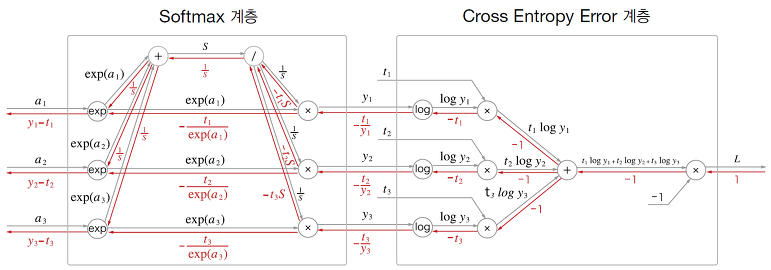

## Neural Network with backpropagation

In [142]:
import sys, os
import numpy as np

from collections import OrderedDict # it memorizes added sequence

sys.path.append(os.pardir)

def numerical_gradient(f, x):
    h = 1e-4
    grad = np.zeros_like(x)

    for idx in np.ndindex(x.shape):
        tmp_val = x[idx]

        x[idx] = tmp_val + h
        fxh1 = f(x)

        x[idx] = tmp_val - h
        fxh2 = f(x)

        grad[idx] = (fxh1 - fxh2) / (2*h)
        x[idx] = tmp_val

    return grad

class TwoLayerNet:

    def __init__(self, input_size, hidden_size, output_size, weight_init_std = 0.01):

        # init params
        self.params = {}
        self.params['W1'] = weight_init_std * np.random.randn(input_size, hidden_size)
        self.params['b1'] = np.zeros(hidden_size)
        self.params['W2'] = weight_init_std * np.random.randn(hidden_size, output_size)
        self.params['b2'] = np.zeros(output_size)

        # create layers
        self.layers = OrderedDict()

        self.layers['Affine1'] = Affine(self.params['W1'], self.params['b1'])
        self.layers['ReLU1'] = ReLU()
        self.layers['Affine2'] = Affine(self.params['W2'], self.params['b2'])

        self.lastLayer = SoftmaxWithLoss()

    def predict(self, x):

        for layer in self.layers.values():
            x = layer.forward(x) # all layers have forward()

        return x
    
    def loss(self, x, t): 

        y = self.predict(x)

        return self.lastLayer.forward(y, t)
    
    def accuracy(self, x, t):

        y = self.predict(x)
        y = np.argmax(y, axis = 1)

        if t.ndim != 1: # if t is one-hot encoding!!
            t = np.argmax(t, axis = 1)

        accuracy = np.sum(y == t) / float(x.shape[0])

        return accuracy
    
    def numerical_gradient(self, x, t):

        loss_W = lambda W: self.loss(x, t)

        grads = {}
        grads['W1'] = numerical_gradient(loss_W, self.params['W1'])
        grads['b1'] = numerical_gradient(loss_W, self.params['b1'])
        grads['W2'] = numerical_gradient(loss_W, self.params['W2'])
        grads['b2'] = numerical_gradient(loss_W, self.params['b2'])
        
        return grads

    def gradient(self, x, t):

        # forward
        self.loss(x, t)

        # backward
        # reverse all layers, and call backward()...
        dout = 1
        dout = self.lastLayer.backward(dout)

        layers = list(self.layers.values())
        layers.reverse()

        for layer in layers:
            dout = layer.backward(dout)

        grads = {}
        grads['W1'] = self.layers['Affine1'].dW
        grads['b1'] = self.layers['Affine1'].db
        grads['W2'] = self.layers['Affine2'].dW
        grads['b2'] = self.layers['Affine2'].db

        return grads

        



## Gradient check

caculating gradient by numerical methods -> slow..
but we can check results by using this.

In [143]:
# Get datasets(16x16 pixel images)
# source code by SNUIML, GPT

from pathlib import Path
import numpy as np

# 1. Get train set
path = Path("trainset.csv")

with path.open() as f: 
    lines = f.readlines()

data = [list(map(int, line.strip().split(','))) for line in lines[1:]]

data = np.array(data)

t_train = data[:, 0]        
x_train = data[:, 1:]

# check
print("x_train.shape:", x_train.shape)
print("t_train.shape:", t_train.shape)

# print(x_train[1][1])

# 2. Get evaluation set
path = Path("evalset.csv")

with path.open() as f: 
    lines = f.readlines()

data = [list(map(int, line.strip().split(','))) for line in lines[1:]]

data = np.array(data)

t_eval = data[:, 0]        
x_eval = data[:, 1:]

# check
print("x_eval.shape:", x_eval.shape)
print("t_eval.shape:", t_eval.shape)

x_train.shape: (300, 256)
t_train.shape: (300,)
x_eval.shape: (300, 256)
t_eval.shape: (300,)


In [144]:
import sys, os
import numpy as np

# Use TwoLayerNet..
# get x_train, t_train, x_test, t_test

network = TwoLayerNet(input_size = 256, hidden_size=50, output_size=10)

x_batch = x_train[:3]
t_batch = t_train[:3]

grad_numerical = network.numerical_gradient(x_batch, t_batch)
grad_backprop = network.gradient(x_batch, t_batch)

for key in grad_numerical.keys():

    diff = np.average(np.abs(grad_backprop[key] - grad_numerical[key]))
    print(key + ":" + str(diff))

# this result means) gradient diff is very small!

W1:1.311138936340608e-07
b1:2.8768378030125305e-09
W2:8.079598557193118e-07
b2:1.1236148532278028e-07


In [148]:
import sys, os
import numpy as np

network = TwoLayerNet(input_size = 256, hidden_size = 50, output_size = 10)

iters_num = 10000
train_size = x_train.shape[0]
batch_size = 100
learning_rate = 0.005

train_loss_list = []
train_acc_list = []
test_acc_list = []

iter_per_epoch = max(train_size / batch_size, 1)

for i in range(iters_num):
    batch_mask = np.random.choice(train_size, batch_size)

    x_batch = x_train[batch_mask]
    t_batch = t_train[batch_mask]

    grad = network.gradient(x_batch, t_batch)

    for key in ('W1', 'b1', 'W2', 'b2'):
        network.params[key] -= learning_rate * grad[key]

    loss = network.loss(x_batch, t_batch)
    train_loss_list.append(loss)

    if i % iter_per_epoch == 0:
        train_acc = network.accuracy(x_train, t_train)
        test_acc = network.accuracy(x_eval, t_eval)

        train_acc_list.append(train_acc)
        test_acc_list.append(test_acc)

        print(train_acc, test_acc)


0.22333333333333333 0.24333333333333335
0.38666666666666666 0.38
0.7066666666666667 0.5933333333333334
0.7266666666666667 0.6333333333333333
0.6933333333333334 0.6233333333333333
0.8866666666666667 0.75
0.7833333333333333 0.6766666666666666
0.8933333333333333 0.76
0.9266666666666666 0.7633333333333333
0.9733333333333334 0.75
0.9566666666666667 0.7666666666666667
0.9766666666666667 0.78
0.93 0.7366666666666667
0.9266666666666666 0.7566666666666667
0.99 0.7566666666666667
1.0 0.8
0.9966666666666667 0.7733333333333333
1.0 0.7766666666666666
1.0 0.7866666666666666
1.0 0.8033333333333333
1.0 0.7933333333333333
1.0 0.7733333333333333
1.0 0.7933333333333333
1.0 0.7933333333333333
1.0 0.7966666666666666
1.0 0.7866666666666666
1.0 0.8
1.0 0.7933333333333333
1.0 0.7866666666666666
1.0 0.7866666666666666
1.0 0.7866666666666666
1.0 0.7933333333333333
1.0 0.7833333333333333
1.0 0.7833333333333333
1.0 0.78
1.0 0.79
1.0 0.78
1.0 0.7866666666666666
1.0 0.79
1.0 0.79
1.0 0.7833333333333333
1.0 0.786666